# <span style="color:red">THE CORRECTED QUESTIONS ARE IN RED FOR QUESTION F AND G</span>


# NOTE: THERE ARE TWO WEIGHTS AND BIASES REPORT FOR HYPERPARAMETER TUNING:
* GRID SEARCH FOR ELASTIC NET [HERE](https://api.wandb.ai/links/rf_project/la0w7e7g)
* GRID SEARCH FOR MINI BATCH GRADIENT DESCENT [HERE](https://wandb.ai/rf_project/HW-1-Sweep/reports/Grid-Search-for-Mini-Batch-Gradient-Descent--VmlldzozNTUwODQx)

## ABOUT THE DATASET
1. Here we are investigating the Fama-French model for stock portfolio returns prediction. We extracted the dataset from [here](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). Here we got the dataframe for the factor model for daily return from 1963 till 2022. The description of the columns are as follows. 
  * SMB (Small Minus Big) is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios
  * HML (High Minus Low) is the average return on the two value portfolios minus the average return on the two growth portfolios,
  * RMW (Robust Minus Weak) is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,
  * CMA (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,
  * Mkt (Market Return): Return for a broad market index like S&P500
  * Rf is the risk-free rate like treasury bill rate.



## AIM OF THE PROJECT
* We all know about WARREN BUFFET and his stress on investing in value stocks instead of growth stocks. Value stocks that have a high book to market ratio, like the utilities companies. Growth stocks are Google and Facebook of the world. They have lower book to market ratio, they have huge growth potential.
* So we have the response column as Berkshire Hathaway portfolio returns from 1990 to 2018. So we will be analyzing the fact whether Warren Buffet has more exposure to Value investing or not. **To showcase that, we need to have more weight for the regression coefficients for the HML column.**. This will reinforce that Warren Buffet had more exposure to value companies, rather than growth or small companies. This is called as **Style analysis** in the literature.

## ABOUT THE DATASET
* We have 5 continuous/numerical column (description are mentioned above)
  * Mkt
  * SMB
  * HML
  * RMW
  * CMA

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('seaborn-dark-palette')
%matplotlib inline

C:\Users\astar\AppData\Local\Temp\ipykernel_10304\729463605.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [2]:
#Reading the dataset
brka_rets = pd.read_csv('brka_d_ret.csv',parse_dates=True, index_col=0)
fff_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV')

In [3]:
#Calculating the compounding for returns
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())
    
brka_m = brka_rets.resample('D').apply(compound).to_period('D')

In [4]:
brka_m['DATE'] = brka_m.index
brka_m['DATE'] = brka_m['DATE'].apply(lambda x:pd.to_datetime(str(x),format='%Y-%m-%d')) 
brka_m.set_index('DATE',inplace=True)

In [5]:
fff_data['DATE'] = fff_data['DATE'].apply(lambda x:pd.to_datetime(str(x),format='%Y-%m-%d')) 

In [6]:
fff_data.set_index('DATE',inplace=True)
# fff_data = fff_data.to_period('M')
fff_data = fff_data/100

#### WE HAVE ABSOLUTE RETURNS FOR EACH PORTFOLIO, BUT WE NEED THE EXCESS RETURN, HENCE WE WILL BE SUBTRACTING THE RISK-FREE RATE

In [7]:
for col in fff_data.columns[1:5]:
    fff_data[col] = fff_data[col]-fff_data['RF']

In [8]:
df = pd.merge(left=brka_m,right=fff_data,left_index=True,how='left',right_index=True)

In [9]:
df['BRKA-RF'] = df['BRKA']-df['RF']
df.head()

,BRKA,Mkt-RF,SMB,HML,RMW,CMA,RF,BRKA-RF
DATE,,,,,,,,
1990-01-02,-0.005764,0.0144,-0.00696,-0.00096,0.00164,-0.00466,0.00026,-0.006024
1990-01-03,0.000000,-0.0006,0.00694,-0.00286,0.00114,-0.00456,0.00026,-0.000260
1990-01-04,0.005797,-0.0071,0.00414,-0.00246,-0.00086,-0.00056,0.00026,0.005537
1990-01-05,-0.005764,-0.0085,0.00714,-0.00236,-0.00036,-0.00146,0.00026,-0.006024
1990-01-06,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### THERE ARE SOME ROWS FOR WHICH WE DON'T HAVE THE DATA, HENCE WE CAN JUST DROP THEM

In [10]:
df.dropna(inplace=True)

In [11]:
df.columns

Index(['BRKA', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'BRKA-RF'], dtype='object')

In [12]:
X_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
y_col = ['BRKA-RF']

In [13]:
df.isna().sum()

BRKA       0
Mkt-RF     0
SMB        0
HML        0
RMW        0
CMA        0
RF         0
BRKA-RF    0
dtype: int64

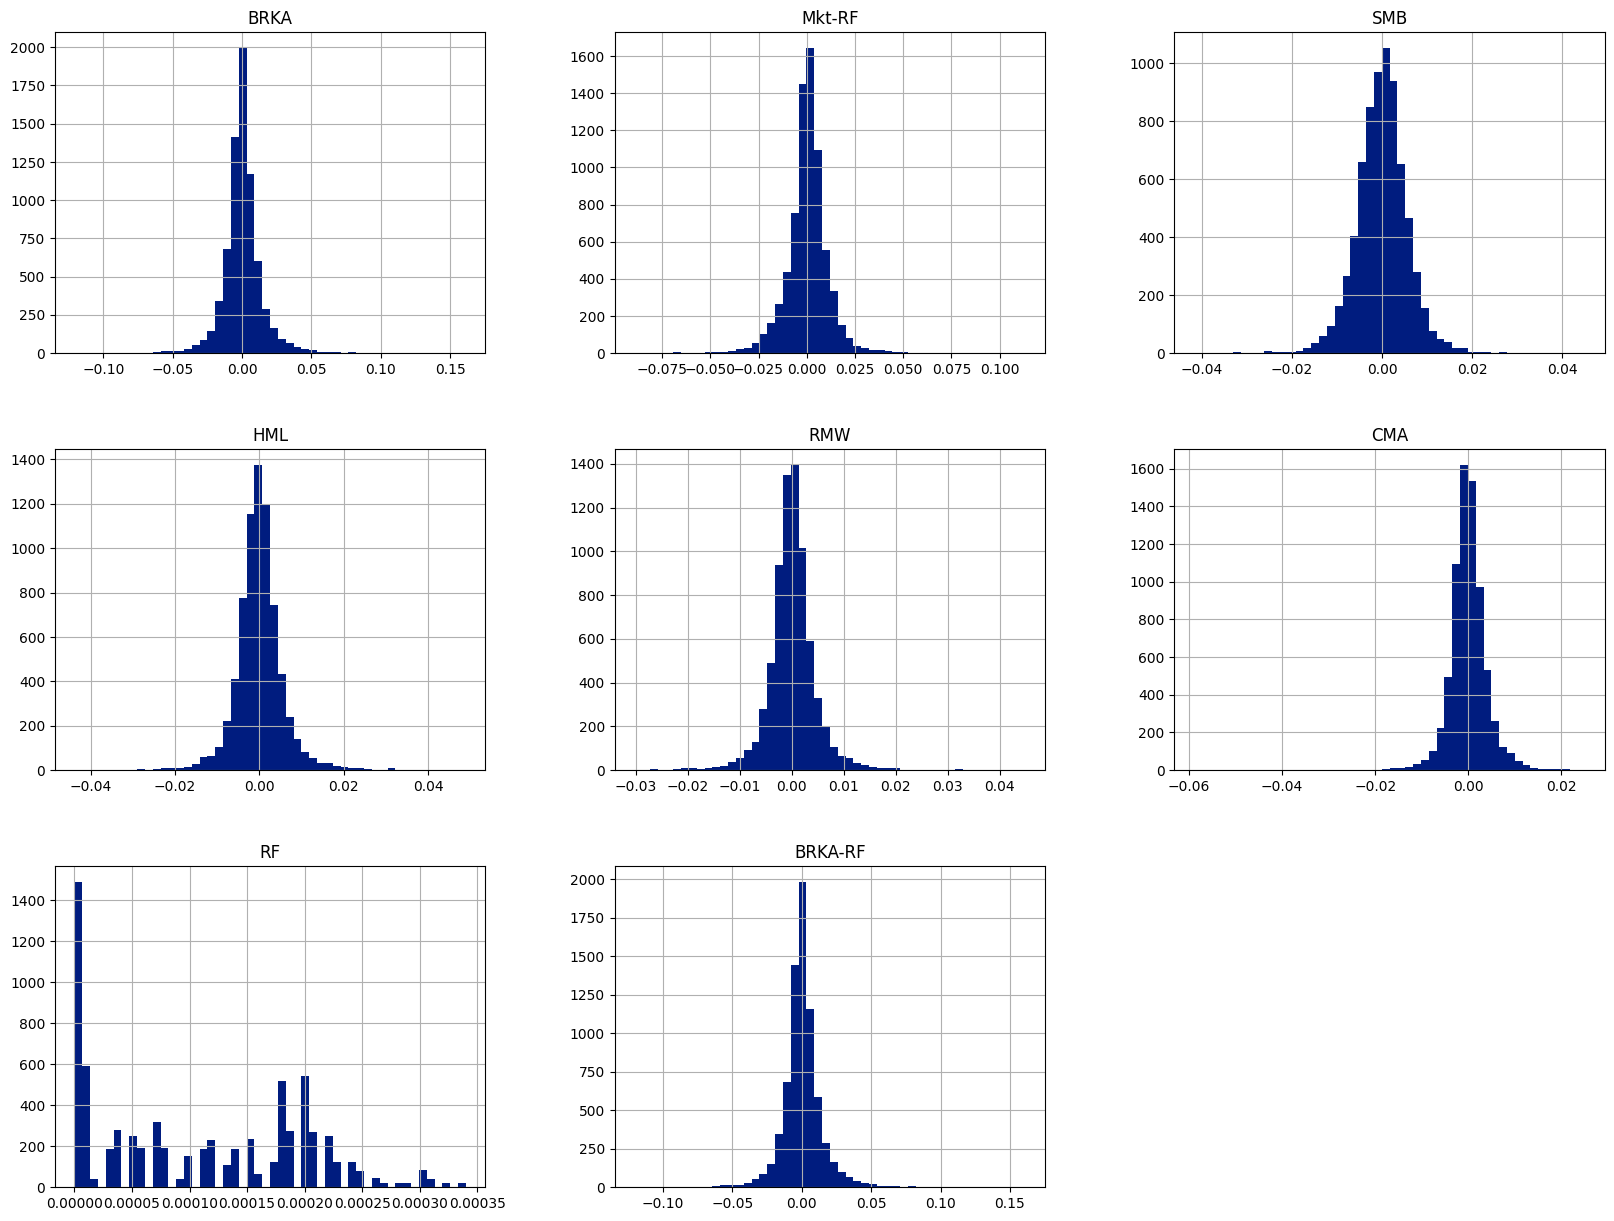

In [55]:
df.hist(bins=50,figsize=(20,15))
plt.show()

In [56]:
df[X_cols+y_col].corr(method="pearson").style.background_gradient(cmap='coolwarm').format(precision=4)


,Mkt-RF,SMB,HML,RMW,CMA,BRKA-RF
Mkt-RF,1.0000,-0.0021,-0.0573,-0.3621,-0.3432,0.4826
SMB,-0.0021,1.0000,0.0512,-0.2925,0.0447,-0.0146
HML,-0.0573,0.0512,1.0000,0.0406,0.5020,0.1246
RMW,-0.3621,-0.2925,0.0406,1.0000,0.2186,-0.2232
CMA,-0.3432,0.0447,0.5020,0.2186,1.0000,-0.1044
BRKA-RF,0.4826,-0.0146,0.1246,-0.2232,-0.1044,1.0000


#### We can see that the response column BRKA-RF is correlated with Market return (Mkt-RF) and HML. This is understandable, as the stock returns are sensitive to the changes in the market because of systematic risk from the market and also the value investing portfolio risks. This is consistent with what we are trying to showcase.

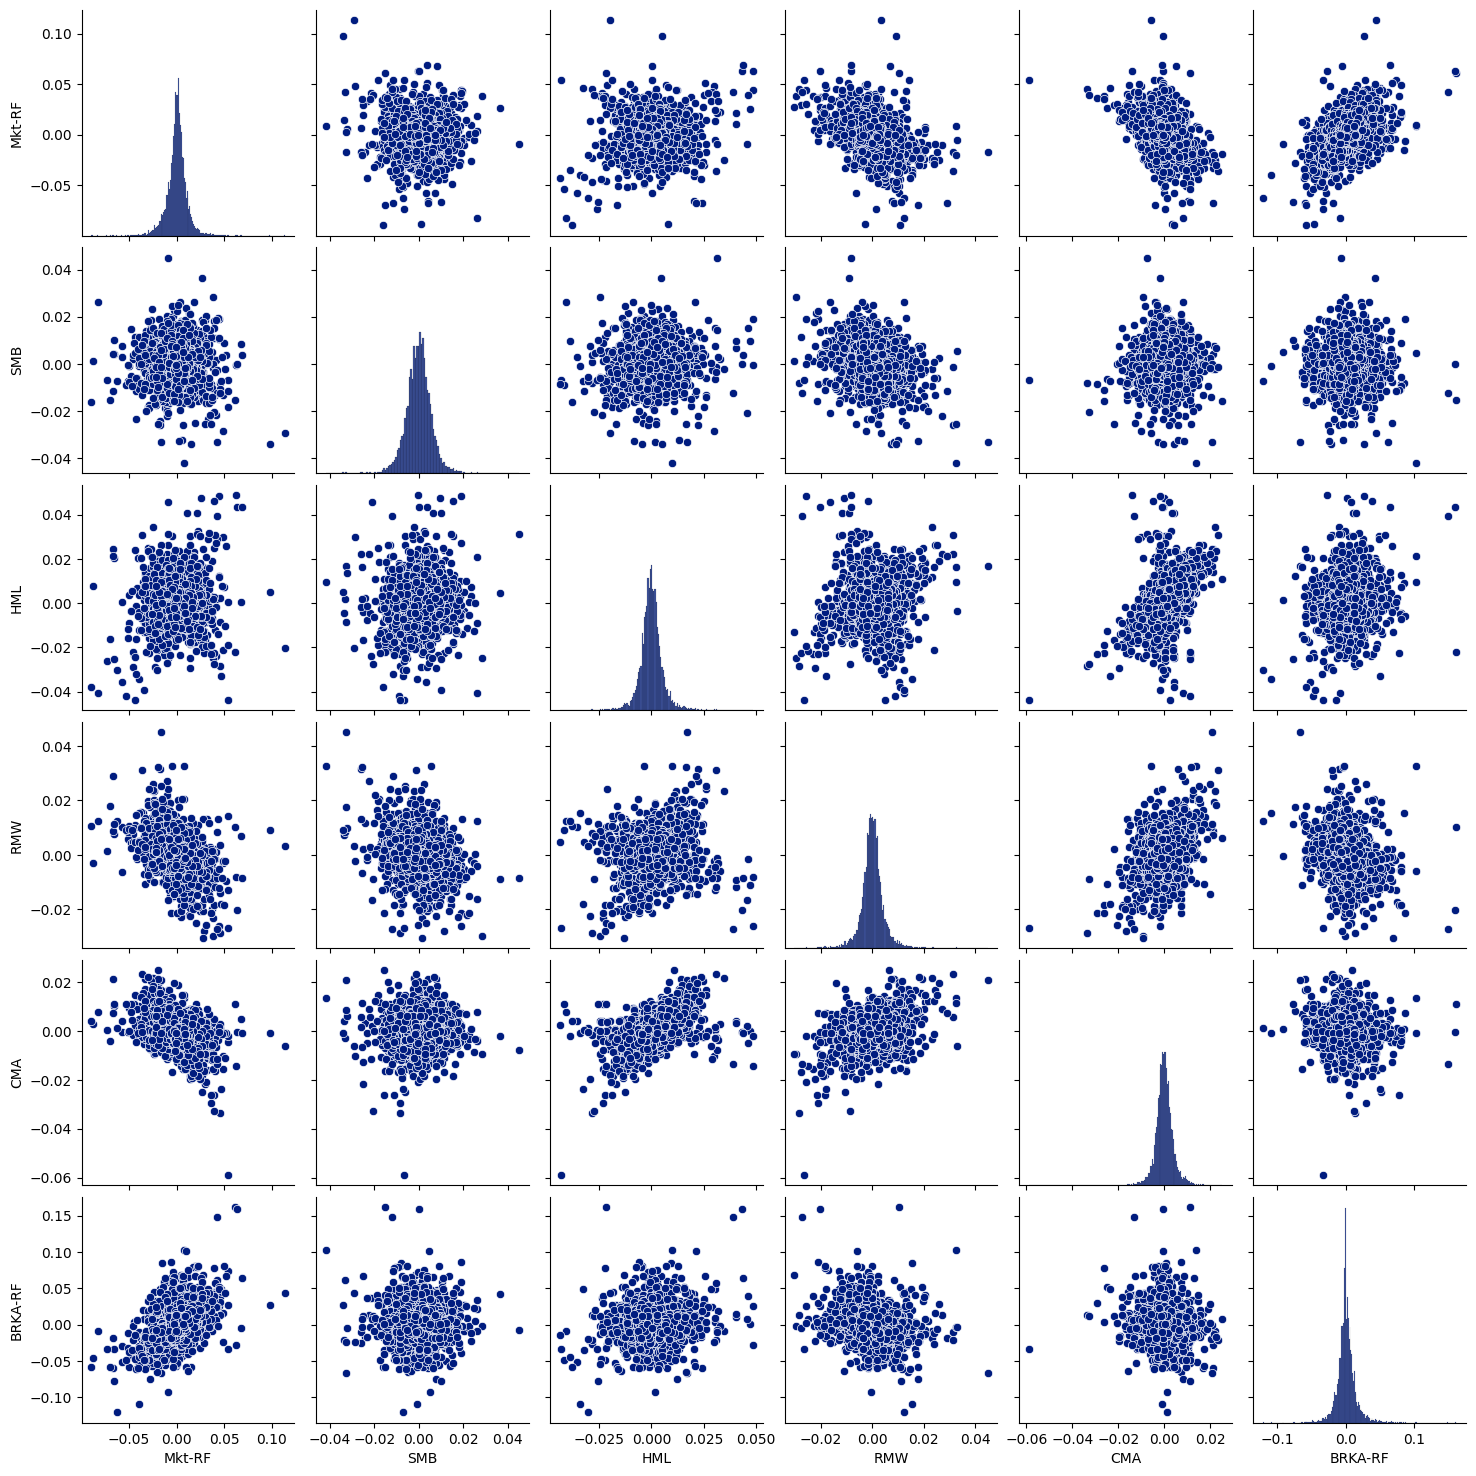

In [57]:
sns.pairplot(df[X_cols+y_col])
plt.show()

## TRAIN TEST SPLIT
* NOTE THAT WE ARE NOT DOING STRATIFIED K-FOLD SPLIT BECAUSE OF THE FOLLOWING REASONS
  * In finance, we should not have any data leakage while training, that is we shouldn't use data from later period to train model in hindsight. Else, it will lead to data leakage from future to past. **THAT'S WHY WE ARE NOT DOING ANY PREPROCESSING, HENCE IT REQUIRES NO TREATMENT**
  * We want to analyze whether **Warren Buffet still a value investor in 2018, if he was a value investor in 1990**. So that's why we are just splitting the data without shuffling into 80% train and 20% test. This will ensure that we don't have any leakage from future returns into the past.

In [14]:
from sklearn.model_selection import train_test_split
X = df[X_cols]
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)

## LINEAR REGRESSION

In [18]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: athe_kunal (rf_project). Use `wandb login --relogin` to force relogin


True

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
lin_reg = LinearRegression()

cv_lin_reg = cross_validate(lin_reg,X_train,y_train,cv=4,scoring='neg_mean_squared_error',return_train_score=True)
print(cv_lin_reg)

lin_reg_ = [-cv_lin_reg['train_score'].mean(),-cv_lin_reg['test_score'].mean()]

print(f"The train loss {lin_reg_[0]}")
print(f"The validation loss {lin_reg_[1]}")

{'fit_time': array([0.04242396, 0.00802445, 0.00701618, 0.00651264]), 'score_time': array([0.        , 0.00811386, 0.00814843, 0.00809455]), 'test_score': array([-0.00015477, -0.00029925, -0.00010753, -0.00018394]), 'train_score': array([-0.00018752, -0.00014185, -0.00020333, -0.00017761])}
The train loss 0.00017757657526451398
The validation loss 0.0001863738067511029


In [16]:
coeff_list = [lin_reg.fit(X_train,y_train).coef_.tolist()[0]]
linear_coeff_df = pd.DataFrame(coeff_list,columns=X_train.columns.tolist())
linear_coeff_df

,Mkt-RF,SMB,HML,RMW,CMA
0,0.554987,-0.095365,0.368667,-0.241933,-0.055945


In [17]:
from sklearn.metrics import mean_squared_error
test_pred = LinearRegression().fit(X_train,y_train).predict(X_test)

print("The test set error is ", mean_squared_error(y_test,test_pred))

The test set error is  4.0494606414400326e-05


#### Linear regression gives high weight to Market returns and HML, this also showcase what we are trying to show that Warren Buffet is a value investor, and his portfolio returns are mostly exposed to Market risks and value portfolio risk

## REGULARIZATION IN LINEAR REGRESSION

In [18]:
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn.model_selection import cross_validate

alpha_list = [0.001,0.01,0.1,1,10]

def regularization_run(X,y,alpha_list:list,scoring=['neg_mean_squared_error']):
    lasso_alpha_dict = {}
    ridge_alpha_dict = {}
    elastic_alpha_dict = {}

    lasso_model,ridge_model,elastic_model = {},{},{}
    for alpha in alpha_list:
        lasso_reg = Lasso(alpha=alpha,random_state=42,fit_intercept=True)

        ridge_reg = Ridge(alpha=alpha,random_state=42,solver='svd')
        
        elastic_reg = ElasticNet(alpha=alpha,random_state=42)

        lasso_res = cross_validate(lasso_reg,X,y,cv=4,scoring=scoring,return_train_score=True)
        ridge_res = cross_validate(ridge_reg,X,y,cv=4,scoring=scoring,return_train_score=True)
        elastic_res = cross_validate(elastic_reg,X,y,cv=4,scoring=scoring,return_train_score=True)
        
        lasso_alpha_dict.update({str(alpha):[-lasso_res['train_neg_mean_squared_error'].mean(),-lasso_res['test_neg_mean_squared_error'].mean()]})
        ridge_alpha_dict.update({str(alpha):[-ridge_res['train_neg_mean_squared_error'].mean(),-ridge_res['test_neg_mean_squared_error'].mean()]})
        elastic_alpha_dict.update({str(alpha):[-elastic_res['train_neg_mean_squared_error'].mean(),-elastic_res['test_neg_mean_squared_error'].mean()]})

        lasso_model.update({str(alpha):lasso_reg.fit(X,y)})
        ridge_model.update({str(alpha):ridge_reg.fit(X,y)})
        elastic_model.update({str(alpha):elastic_reg.fit(X,y)})
        
    return lasso_alpha_dict,ridge_alpha_dict,elastic_alpha_dict,lasso_model,ridge_model,elastic_model

lasso_alpha_dict,ridge_alpha_dict,elastic_alpha_dict,lasso_model,ridge_model,elastic_model = regularization_run(X_train,y_train,alpha_list)

## LASSO REGRESSION

In [19]:
import pprint
pprint.pprint(lasso_alpha_dict)

{'0.001': [0.0002311042768677043, 0.00023114109426687672],
 '0.01': [0.0002311042768677043, 0.00023114109426687672],
 '0.1': [0.0002311042768677043, 0.00023114109426687672],
 '1': [0.0002311042768677043, 0.00023114109426687672],
 '10': [0.0002311042768677043, 0.00023114109426687672]}


<AxesSubplot:title={'center':'Lasso Regression'}, xlabel='Alpha', ylabel='MSE'>

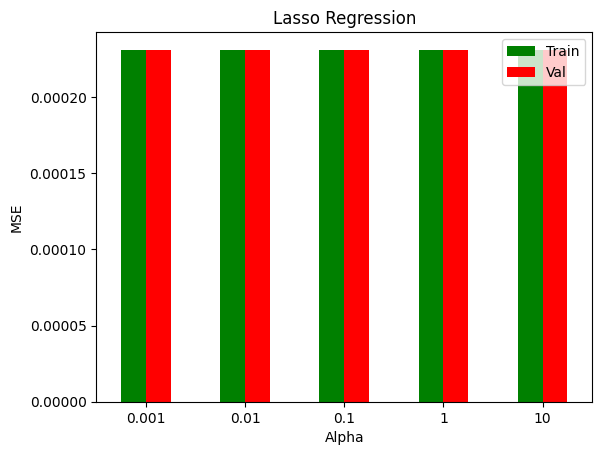

In [20]:
train_color,val_color = 'green','red'
lasso_df = pd.DataFrame(lasso_alpha_dict).T
lasso_df.columns = ['Train','Val']
lasso_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Lasso Regression',xlabel='Alpha',ylabel='MSE')

In [22]:
#Coefficients

val_list = [[key]+lasso_model[key].coef_.tolist()+[lasso_model[key].intercept_.round(7)] for key in lasso_alpha_dict.keys()]
lasso_coeff_df = pd.DataFrame(val_list,columns=['Alpha Value']+X_train.columns.tolist()+['Intercept'])
lasso_coeff_df

,Alpha Value,Mkt-RF,SMB,HML,RMW,CMA,Intercept
0,0.001,0.0,-0.0,0.0,-0.0,-0.0,[0.0004783]
1,0.01,0.0,-0.0,0.0,-0.0,-0.0,[0.0004783]
2,0.1,0.0,-0.0,0.0,-0.0,-0.0,[0.0004783]
3,1,0.0,-0.0,0.0,-0.0,-0.0,[0.0004783]
4,10,0.0,-0.0,0.0,-0.0,-0.0,[0.0004783]


In [23]:
test_pred = Lasso(alpha=0.001).fit(X_train,y_train).predict(X_test)

print("The test set error is ", mean_squared_error(y_test,test_pred))

The test set error is  9.495850733174149e-05


#### LASSO REGRESSION PENALIZED ALL THE COLUMNS, AND IT SUGGESTS THAT THE INTERCEPT OR THE MEAN OF ALL RETURNS IS A BETTER PREDICTOR FOR THE MODEL INSTEAD OF THE INDIVIDUAL PORTFOLIO RETURNS. 
**Hence Lasso is a sparse model**

## RIDGE REGRESSION

<AxesSubplot:title={'center':'Ridge Regression'}, xlabel='Alpha', ylabel='MSE'>

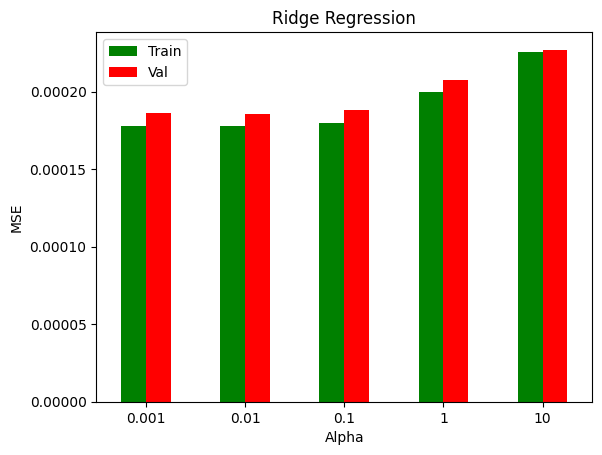

In [24]:
train_color,val_color = 'green','red'
ridge_df = pd.DataFrame(ridge_alpha_dict).T
ridge_df.columns = ['Train','Val']
ridge_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Ridge Regression',xlabel='Alpha',ylabel='MSE')

In [25]:
val_list = [[key]+ridge_model[key].coef_.tolist()[0] for key in ridge_alpha_dict.keys()]
ridge_coeff_df = pd.DataFrame(val_list,columns=['Alpha Value']+X_train.columns.tolist())
ridge_coeff_df

,Alpha Value,Mkt-RF,SMB,HML,RMW,CMA
0,0.001,0.554646,-0.094405,0.366510,-0.240282,-0.054735
1,0.01,0.551218,-0.086515,0.348550,-0.226692,-0.045673
2,0.1,0.505743,-0.046191,0.240587,-0.155471,-0.019888
3,1,0.255817,-0.007699,0.058493,-0.056359,-0.017174
4,10,0.042938,-0.000854,0.006400,-0.008845,-0.003795


#### Unlike Lasso, Ridge is not a sparse model, and it decreases the coefficients, but not to 0.

In [66]:
test_pred = Ridge(alpha=0.001).fit(X_train,y_train).predict(X_test)

print("The test set error is ", mean_squared_error(y_test,test_pred))

The test set error is  4.053191115419804e-05


## ELASTIC REGRESSION WITH VARYING ALPHA

In [26]:
pprint.pprint(elastic_alpha_dict)

{'0.001': [0.0002311042768677043, 0.00023114109426687672],
 '0.01': [0.0002311042768677043, 0.00023114109426687672],
 '0.1': [0.0002311042768677043, 0.00023114109426687672],
 '1': [0.0002311042768677043, 0.00023114109426687672],
 '10': [0.0002311042768677043, 0.00023114109426687672]}


In [27]:
val_list = [[key]+ridge_model[key].coef_.tolist()[0] for key in elastic_alpha_dict.keys()]
elastic_coeff_df = pd.DataFrame(val_list,columns=['Alpha Value']+X_train.columns.tolist())
elastic_coeff_df

,Alpha Value,Mkt-RF,SMB,HML,RMW,CMA
0,0.001,0.554646,-0.094405,0.366510,-0.240282,-0.054735
1,0.01,0.551218,-0.086515,0.348550,-0.226692,-0.045673
2,0.1,0.505743,-0.046191,0.240587,-0.155471,-0.019888
3,1,0.255817,-0.007699,0.058493,-0.056359,-0.017174
4,10,0.042938,-0.000854,0.006400,-0.008845,-0.003795


<AxesSubplot:title={'center':'Elastic Regression'}, xlabel='Alpha', ylabel='MSE'>

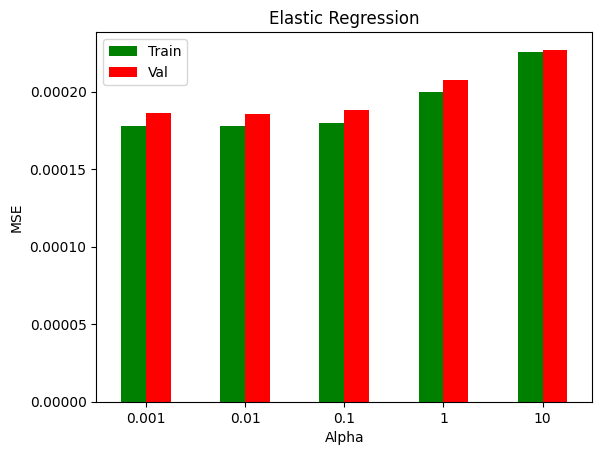

In [28]:
train_color,val_color = 'green','red'
elastic_df = pd.DataFrame(ridge_alpha_dict).T
elastic_df.columns = ['Train','Val']
elastic_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Elastic Regression',xlabel='Alpha',ylabel='MSE')

In [67]:
test_pred = ElasticNet(alpha=0.001).fit(X_train,y_train).predict(X_test)

print("The test set error is ", mean_squared_error(y_test,test_pred))

The test set error is  9.495850733174149e-05


## COMPARISON BETWEEN RIDGE, LASSO AND ELASTIC

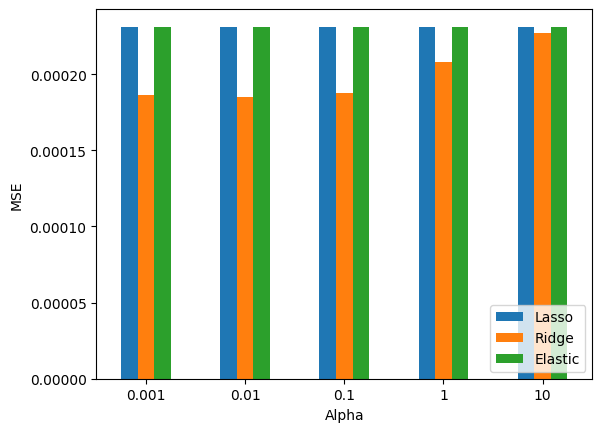

In [33]:
combined_list = [[lasso_alpha_dict[key][1],ridge_alpha_dict[key][1],elastic_alpha_dict[key][1]]for key in lasso_alpha_dict.keys()]

combined_df = pd.DataFrame(combined_list,columns=['Lasso','Ridge','Elastic'],index=lasso_alpha_dict.keys())
combined_df.plot.bar(rot=0,xlabel='Alpha',ylabel="MSE")
# plt.figure(figsize=(20,10))
plt.legend(loc='lower right')

* So the Ridge regression tends to perform better than both Elastic with varying alpha and Lasso regression. This signifies that the feature values have some importance in predicting the stock returns 

## ELASTIC REGRESSION WITH VARYING ALPHA AND L1 RATIO

In [34]:
from sklearn.model_selection import GridSearchCV
import numpy as np
params_grid = {
    "alpha": alpha_list,
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}

elastic_net = ElasticNet()
elasticnet_grid = GridSearchCV(elastic_net,param_grid=params_grid,n_jobs=-1,cv=4,return_train_score=True,scoring='neg_mean_squared_error')

elasticnet_grid.fit(X_train,y_train)

c:\Users\astar\anaconda3\envs\PyTorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.580e-01, tolerance: 1.351e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=4, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [35]:
elasticnet_grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.0}

#### PLEASE DON'T RUN THE CELLS BELOW AS IT REQUIRES WEIGHTS AND BIASES API CODE

#### YOU CAN FIND THE REPORT FOR THE FOLLOWING RUN [HERE](https://wandb.ai/rf_project/HW-1-Sweep/reports/Grid-Search-for-elastic-net-regression--VmlldzozNTQ4NTUw) ON WEIGHTS AND BIASES

In [40]:
alpha_list=[0.001, 0.01, 0.1, 1, 10]
l1_ratio_list = np.arange(0.0,1.0,0.1).tolist()

sweep_config = {
    "method":"grid",
    'parameters':{
    "alpha":{"values":alpha_list},
    "l1_ratio":{"values":l1_ratio_list}}
}

def main():
    run =wandb.init("HW-1-Sweep")

    alpha = wandb.config.alpha
    l1_ratio = wandb.config.l1_ratio

    elastic_reg = ElasticNet(alpha=alpha,l1_ratio=l1_ratio)
    elastic_res = cross_validate(elastic_reg,X_train,y_train,scoring=['neg_mean_squared_error'],cv=4,return_train_score=True)

    wandb.log({
        "train_MSE":-np.mean(elastic_res['train_neg_mean_squared_error']),
        "val_MSE":-np.mean(elastic_res['test_neg_mean_squared_error'])
    })

sweep_id = wandb.sweep(sweep=sweep_config, project='HW-1-Sweep')
wandb.agent(sweep_id, function=main)

* From the report we can see that the grid search suggests that we need smaller alpha values and l1 ratio of 0.0, that is use ridge regression instead of lasso regression. 

In [68]:
test_pred = ElasticNet(alpha=0.001,l1_ratio=0.0).fit(X_train,y_train).predict(X_test)

print("The test set error is ", mean_squared_error(y_test,test_pred))

The test set error is  8.617994198964314e-05


In [36]:
val_list = [elasticnet_grid.best_estimator_.coef_.tolist()+[elasticnet_grid.best_estimator_.intercept_[0]]]
elastic_coeff_df = pd.DataFrame(val_list,columns=X_train.columns.tolist()+['Intercept'])
elastic_coeff_df

,Mkt-RF,SMB,HML,RMW,CMA,Intercept
0,0.069717,-0.001444,0.010916,-0.014442,-0.006011,0.000459


### FEATURE IMPORTANCE

In [37]:
from sklearn.inspection import permutation_importance

elastic_best_model = ElasticNet(alpha=0.001,l1_ratio=0.0).fit(X_train,y_train)
ridge_imps = permutation_importance(ridge_model['0.01'],X,y,n_repeats=100,random_state=42).importances_mean
elastic_imps = permutation_importance(elastic_best_model,X,y,n_repeats=100,random_state=42).importances_mean
lasso_imps = permutation_importance(lasso_model['0.01'],X,y,n_repeats=100,random_state=42).importances_mean

c:\Users\astar\anaconda3\envs\PyTorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.580e-01, tolerance: 1.351e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [38]:
feature_importance = pd.DataFrame([ridge_imps,elastic_imps,lasso_imps],columns=X_train.columns,index=['Ridge','Elastic Net','Lasso'])
feature_importance

,Mkt-RF,SMB,HML,RMW,CMA
Ridge,0.391028,0.002869,0.047076,0.011925,0.000341
Elastic Net,0.051676,0.000018,0.001182,0.001886,0.000294
Lasso,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

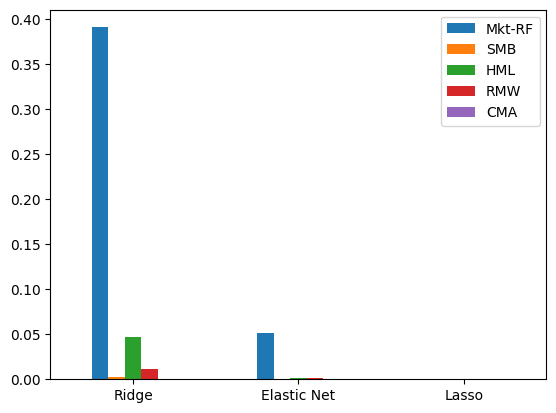

In [39]:
feature_importance.plot.bar(rot=0)

#### HERE WE ALSO GOT HIGHER FEATURE IMPORTANCE FOR THE MARKET RETURN AND HML (VALUE INVESTING PORTFOLIO). SO OUR OBJECTIVE HAS BEEN SHOWN HERE THAT WARREN BUFFET IS INDEED A VALUE INVESTOR

## STOCHASTIC GRADIENT DESCENT

In [20]:
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
m = len(X_train)
np.random.seed(42)

import math
from tqdm import tqdm

def get_batches(X:pd.DataFrame,y:pd.DataFrame,batch_size:int):
    num_train = X.shape[0]

    indices = np.arange(num_train)
    np.random.shuffle(indices)

    for start_idx in range(0,num_train,batch_size):
        #Ensures that we pick the required number of elements till the last element
        end_idx = min(start_idx+batch_size,num_train)
        batch_idx = indices[start_idx:end_idx]

        yield X.values[batch_idx],y.values[batch_idx]

def get_loss(X,y,weights_list:list):
    losses = []
    val_len = X.shape[0]
    for weight in weights_list:
        curr_weight_loss = 0.0
        for validation_data in zip(X.values,y.values):
            X_curr,y_curr = validation_data
            y_pred = X_curr@weight
            curr_weight_loss+=(y_pred[0]-y_curr)**2
        losses.append(curr_weight_loss/val_len)
    return losses

def learning_rate_scheduler(curr_iter:int,initial_lr:float):
    return initial_lr/math.exp(curr_iter)
    
def minibatch_sgd(X,y,batch_size:int=32,lr0:float=0.1,num_epochs:int=100):
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X,y,test_size=0.1,random_state=42,shuffle=True)
    weight_path_sgd = []
    weight = np.random.randn(X_train_.shape[1],1) 
    train_loss = []
    # scale = X_train_.shape[0]//batch_size
    for epoch in tqdm(range(num_epochs)):
        batch_iterator = get_batches(X_train_,y_train_,batch_size)
        curr_train_loss = 0.0
        for idx,batches in enumerate(batch_iterator):
            X_curr,y_curr = batches
            # y_curr = np.expand_dims(y_curr,axis=1)
            grads = 2/batch_size * X_curr.T.dot(X_curr.dot(weight) - y_curr)
            # eta = learning_rate_scheduler(idx/scale,lr0)
            weight = weight - lr0*grads
        train_loss.append(get_loss(X_train_,y_train_,[weight])[0])
        weight_path_sgd.append(weight)
    val_loss = get_loss(X_val_,y_val_,weight_path_sgd)

    return weight_path_sgd,train_loss,val_loss


In [30]:
%%time
_,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=0.001,num_epochs=200,batch_size=16)

100%|██████████| 200/200 [00:12<00:00, 16.18it/s]


CPU times: total: 7.73 s
Wall time: 13.5 s


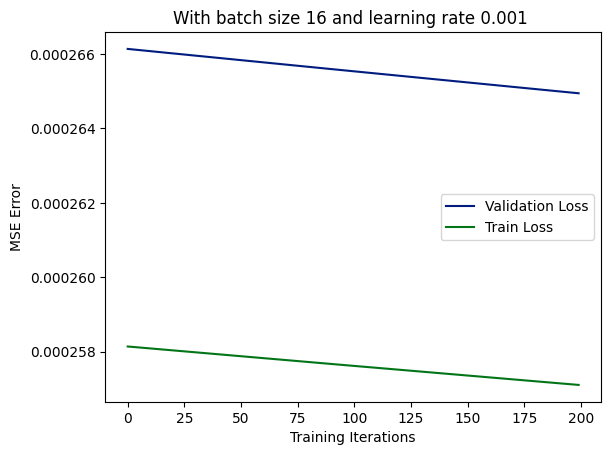

In [31]:
import matplotlib.pyplot as plt
plt.plot(val_loss,label='Validation Loss')
plt.plot(train_loss,label='Train Loss')
# plt.plot(test_loss,label='Test Loss')
plt.xlabel('Training Iterations')
plt.ylabel('MSE Error')
plt.title(f'With batch size {16} and learning rate {0.001} ')
# plt.ylim(min(min(val_loss),min(train_loss)),max(max(val_loss),max(train_loss)))
plt.legend()

In [32]:
%%time
_,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=0.001,num_epochs=100,batch_size=1)

100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


CPU times: total: 13.5 s
Wall time: 21.6 s


Text(5, 5, 'Batch size: 16, learning rate:0.0001')

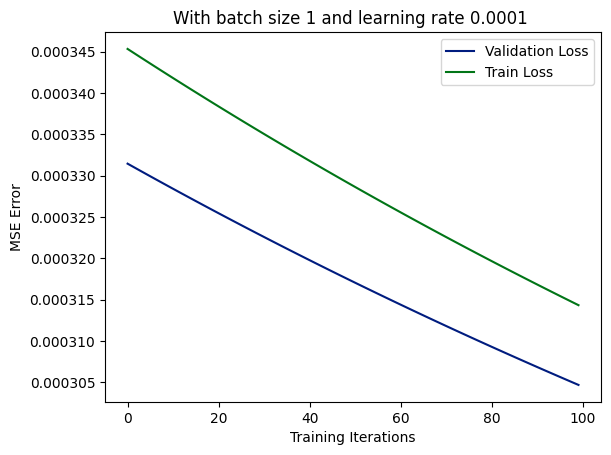

In [33]:
import matplotlib.pyplot as plt
plt.plot(val_loss,label='Validation Loss')
plt.plot(train_loss,label='Train Loss')
# plt.plot(test_loss,label='Test Loss')
plt.xlabel('Training Iterations')
plt.ylabel('MSE Error')
plt.title(f'With batch size {1} and learning rate {0.0001} ')
# plt.ylim(min(min(val_loss),min(train_loss)),max(max(val_loss),max(train_loss)))
plt.legend()
plt.annotate(text=f"Batch size: {16}, learning rate:{0.0001}",xy=[5,5])

In [34]:
%%time
_,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=0.01,num_epochs=100,batch_size=1)

100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


CPU times: total: 12.8 s
Wall time: 20.7 s


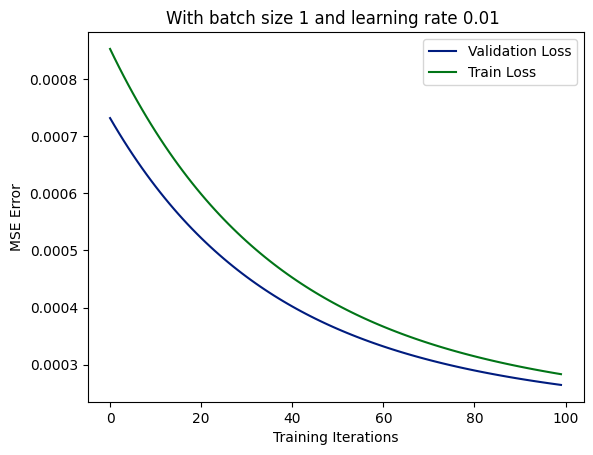

In [35]:
fig,ax = plt.subplots(1,1)
ax.plot(val_loss,label='Validation Loss')
ax.plot(train_loss,label='Train Loss')
# plt.plot(test_loss,label='Test Loss')
ax.set_xlabel('Training Iterations')
ax.set_ylabel('MSE Error')
ax.set_title(f'With batch size {1} and learning rate {0.01} ')
ax.legend()

In [36]:
%%time
weight_path_sgd,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=0.01,num_epochs=100,batch_size=16)

100%|██████████| 100/100 [00:06<00:00, 15.77it/s]


CPU times: total: 3.86 s
Wall time: 6.9 s


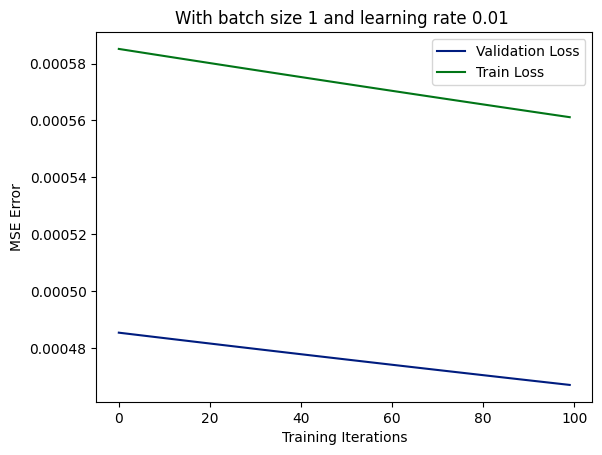

In [44]:
fig,ax = plt.subplots(1,1)
ax.plot(val_loss,label='Validation Loss')
ax.plot(train_loss,label='Train Loss')
# plt.plot(test_loss,label='Test Loss')
ax.set_xlabel('Training Iterations')
ax.set_ylabel('MSE Error')
ax.set_title(f'With batch size {1} and learning rate {0.01} ',loc='center')
ax.legend()

In [38]:
print('The test loss is: ')
get_loss(X_test,y_test,[weight_path_sgd[-1]])[0]

The test loss is: 


array([0.00026878])

#### PLEASE DON'T RUN THE CELLS BELOW AS IT REQUIRES WEIGHTS AND BIASES API CODE

#### YOU CAN FIND THE REPORT FOR THE FOLLOWING RUN [HERE](https://wandb.ai/rf_project/HW-1-Sweep/reports/Grid-Search-for-Mini-Batch-Gradient-Descent--VmlldzozNTUwODQx) ON WEIGHTS AND BIASES

In [46]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: athe_kunal (rf_project). Use `wandb login --relogin` to force relogin


True

In [48]:
import time

lr_list=[0.0001, 0.001, 0.01, 0.1]
batch_size_list = [1,8,16,32,64]

sweep_config_SGD = {
    "method":"grid",
    'parameters':{
    "lr0":{"values":lr_list},
    "minibatch_size":{"values":batch_size_list}}
}

def sgd_main():
    run =wandb.init("HW-1-Sweep")

    lr0 = wandb.config.lr0
    minibatch_size = wandb.config.minibatch_size

    start_time = time.time()
    _,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=lr0,num_epochs=100,batch_size=minibatch_size)

    end_time = time.time()
    plt.plot(val_loss,label='Validation Loss')
    plt.plot(train_loss,label='Train Loss')
    # plt.plot(test_loss,label='Test Loss')
    plt.xlabel('Training Iterations')
    plt.ylabel('MSE Error')
    plt.title(f'With batch size {minibatch_size} and learning rate {lr0} ',loc='center')
    ax.legend()

    wandb.log({
        "learning_curve":plt,
        "time_taken":end_time-start_time,
        "train_loss":train_loss[-1],
        "val_loss":val_loss[-1],

    })

sweep_id_sgd = wandb.sweep(sweep=sweep_config_SGD, project='HW-1-Sweep')
wandb.agent(sweep_id_sgd, function=sgd_main)

## ACCORDING TO THE RUN, THE BEST HYPERPARAMETERS ARE BATCH SIZE OF 1 AND LEARNING RATE OF 0.1

## FITTING WITH BEST HYPERPARAMETERS

In [49]:
%%time
weight_path_sgd,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=0.1,num_epochs=100,batch_size=1)

100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


CPU times: total: 13.6 s
Wall time: 21.9 s


In [50]:
print('The test loss is: ')
get_loss(X_test,y_test,[weight_path_sgd[-1]])[0]

The test loss is: 


array([4.0615349e-05])

#### OBSERVATIONS
1. As batch size increases, the time taken to complete the run decreases. For Stochastic Gradient Descent, we have the highest amount of time taken to complete the run
2. Also, the plots for SGD have lot of variations and noise, this aligns with the fact that SGD updates are noisy
3. For SGD, we have higher discrepancy between the train and validation set, as it signals overfitting. But mini-batch gradient descent is faster and has less sign of overfitting.

## POLYNOMIAL REGRESSION

# <span style="color:red">QUESTION F</span>


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso,Ridge, LinearRegression,ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

degree_list = [2,3,5]
lin_reg_poly = {}
lin_reg_poly_model = {}
lasso_alpha_dict = {}
ridge_alpha_dict = {}
elastic_alpha_dict = {}
sgd_deg_dict = {}

#Take a subset of train data columns
X_sub_train = X_train[X_train.columns[:7]]
for deg in degree_list:
    poly_transform = PolynomialFeatures(degree=deg,interaction_only=True)
    cv_poly_reg = LinearRegression()
    cv_poly_lasso_reg = Lasso()
    cv_poly_ridge_reg = Ridge()
    cv_elastic_poly_reg =  ElasticNet()
    
    X_poly = poly_transform.fit_transform(X_sub_train)
    X_poly = pd.DataFrame(X_poly)
    cv_lin_reg_poly = cross_validate(cv_poly_reg,X_poly,y_train,cv=4,scoring='neg_mean_squared_error',return_train_score=True,n_jobs=-1)
    lasso_res = cross_validate(cv_poly_lasso_reg,X,y,cv=4,scoring='neg_mean_squared_error',return_train_score=True)
    ridge_res = cross_validate(cv_poly_ridge_reg,X,y,cv=4,scoring='neg_mean_squared_error',return_train_score=True)
    elastic_res = cross_validate(cv_elastic_poly_reg,X,y,cv=4,scoring='neg_mean_squared_error',return_train_score=True)
    lasso_alpha_dict.update({str(deg):[-lasso_res['train_score'].mean(),-lasso_res['test_score'].mean()]})
    ridge_alpha_dict.update({str(deg):[-ridge_res['train_score'].mean(),-ridge_res['test_score'].mean()]})
    elastic_alpha_dict.update({str(deg):[-elastic_res['train_score'].mean(),-elastic_res['test_score'].mean()]})
    lin_reg_poly.update({f'{deg}':[-cv_lin_reg_poly['train_score'].mean(),-cv_lin_reg_poly['test_score'].mean()]})

    weight_path_sgd,train_loss,val_loss = minibatch_sgd(X_poly,y_train,lr0=0.01,num_epochs=50,batch_size=32)
    
    sgd_deg_dict.update({str(deg):[train_loss,val_loss]})

100%|██████████| 50/50 [00:03<00:00, 16.27it/s]


In [22]:
train_color,val_color = 'green','red'
poly_df = pd.DataFrame(lin_reg_poly).T
poly_df.columns = ['Train','Val']
print(poly_df)

      Train       Val
2  0.000176  0.000191
3  0.000170  0.000202
5  0.000168  0.000254


<Axes: title={'center': 'Polynomial Linear Regression'}, xlabel='Degree', ylabel='MSE'>

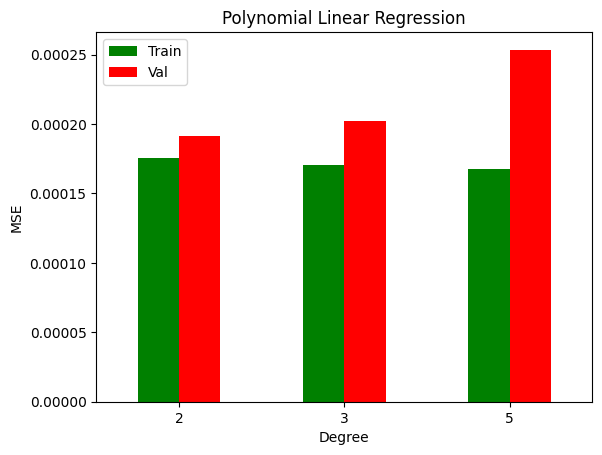

In [23]:
poly_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Polynomial Linear Regression',xlabel='Degree',ylabel='MSE')

      Train       Val
2  0.000204  0.000204
3  0.000204  0.000204
5  0.000204  0.000204


<Axes: title={'center': 'Polynomial Lasso Regression'}, xlabel='Degree', ylabel='MSE'>

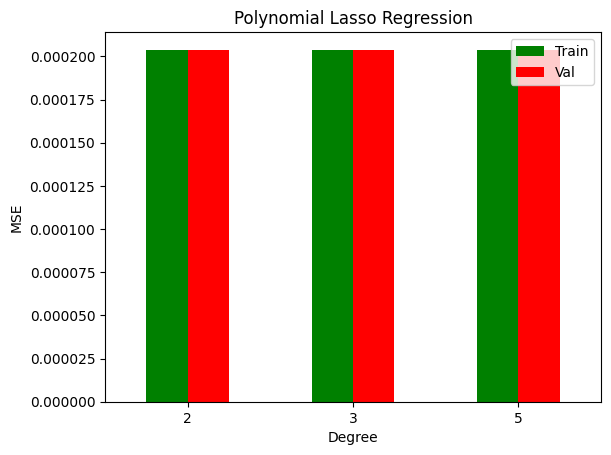

In [24]:
train_color,val_color = 'green','red'
poly_df = pd.DataFrame(lasso_alpha_dict).T
poly_df.columns = ['Train','Val']
print(poly_df)

poly_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Polynomial Lasso Regression',xlabel='Degree',ylabel='MSE')

      Train       Val
2  0.000171  0.000174
3  0.000171  0.000174
5  0.000171  0.000174


<Axes: title={'center': 'Polynomial Ridge Regression'}, xlabel='Degree', ylabel='MSE'>

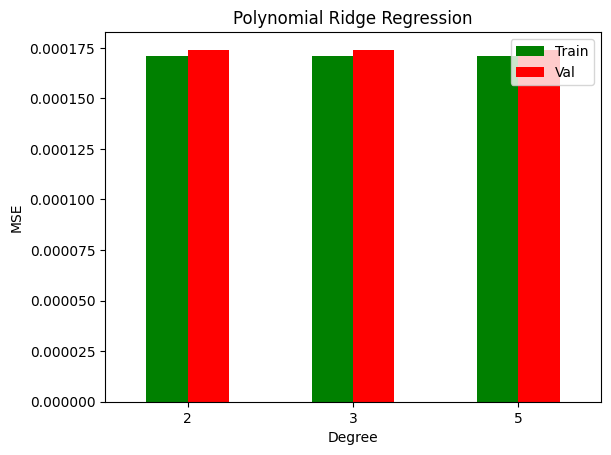

In [25]:
train_color,val_color = 'green','red'
poly_df = pd.DataFrame(ridge_alpha_dict).T
poly_df.columns = ['Train','Val']
print(poly_df)

poly_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Polynomial Ridge Regression',xlabel='Degree',ylabel='MSE')

      Train       Val
2  0.000204  0.000204
3  0.000204  0.000204
5  0.000204  0.000204


<Axes: title={'center': 'Polynomial Elastic Regression'}, xlabel='Degree', ylabel='MSE'>

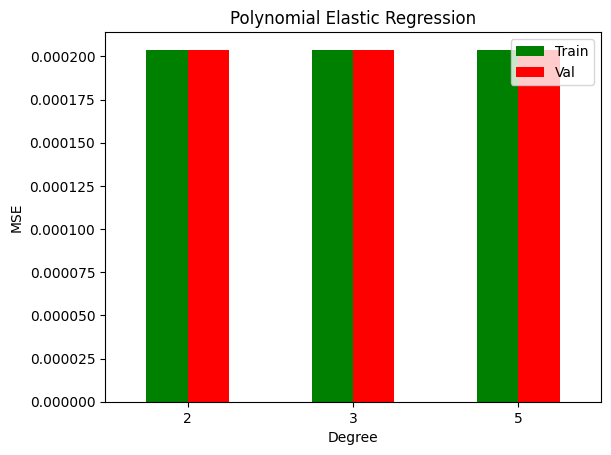

In [26]:
train_color,val_color = 'green','red'
poly_df = pd.DataFrame(elastic_alpha_dict).T
poly_df.columns = ['Train','Val']
print(poly_df)

poly_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Polynomial Elastic Regression',xlabel='Degree',ylabel='MSE')

* We can see that as we increase the degree of the polynomial, the overfitting issue gets amplified. The training error decreases with higher degree, but the validation error continues to widen up. This signals overfitting, and the degree 2 is the best degree hyperparameter.
* We can also see from degree 2 to 3, the disparity between the two error increasing a lot, signaling overfitting. It is prevalent for Linear regression only
* But for ridge, lasso and elastic, the overfitting is not pronounced as they are doing feature selection by reducing their weight or by sparse regression. So for polynomial features, we can do regularization for eliminating some features.

#### FITTING WITH DEGREE 2

In [43]:
poly_transform = PolynomialFeatures(degree=2,interaction_only=False)
cv_poly_reg = LinearRegression()
X_poly = poly_transform.fit_transform(X_train)
X_poly_test = poly_transform.fit_transform(X_test)
cv_poly_reg.fit(X_poly,y_train)
test_preds = cv_poly_reg.predict(X_poly_test)
print("The error for test set is: ")
mean_squared_error(y_test,test_preds)

The error for test set is: 


4.1686946570443196e-05

In [29]:
poly_transform = PolynomialFeatures(degree=2,interaction_only=False)
cv_poly_reg = Lasso()
X_poly = poly_transform.fit_transform(X_train)
X_poly_test = poly_transform.fit_transform(X_test)
cv_poly_reg.fit(X_poly,y_train)
test_preds = cv_poly_reg.predict(X_poly_test)
print("The error for test set is: ")
mean_squared_error(y_test,test_preds)

The error for test set is: 


9.495850733174149e-05

In [30]:
poly_transform = PolynomialFeatures(degree=2,interaction_only=False)
cv_poly_reg = Ridge()
X_poly = poly_transform.fit_transform(X_train)
X_poly_test = poly_transform.fit_transform(X_test)
cv_poly_reg.fit(X_poly,y_train)
test_preds = cv_poly_reg.predict(X_poly_test)
print("The error for test set is: ")
mean_squared_error(y_test,test_preds)

The error for test set is: 


6.587646794990832e-05

In [31]:
poly_transform = PolynomialFeatures(degree=2,interaction_only=False)
cv_poly_reg = ElasticNet()
X_poly = poly_transform.fit_transform(X_train)
X_poly_test = poly_transform.fit_transform(X_test)
cv_poly_reg.fit(X_poly,y_train)
test_preds = cv_poly_reg.predict(X_poly_test)
print("The error for test set is: ")
mean_squared_error(y_test,test_preds)

The error for test set is: 


9.495850733174149e-05

In [33]:
# sgd_deg_dict

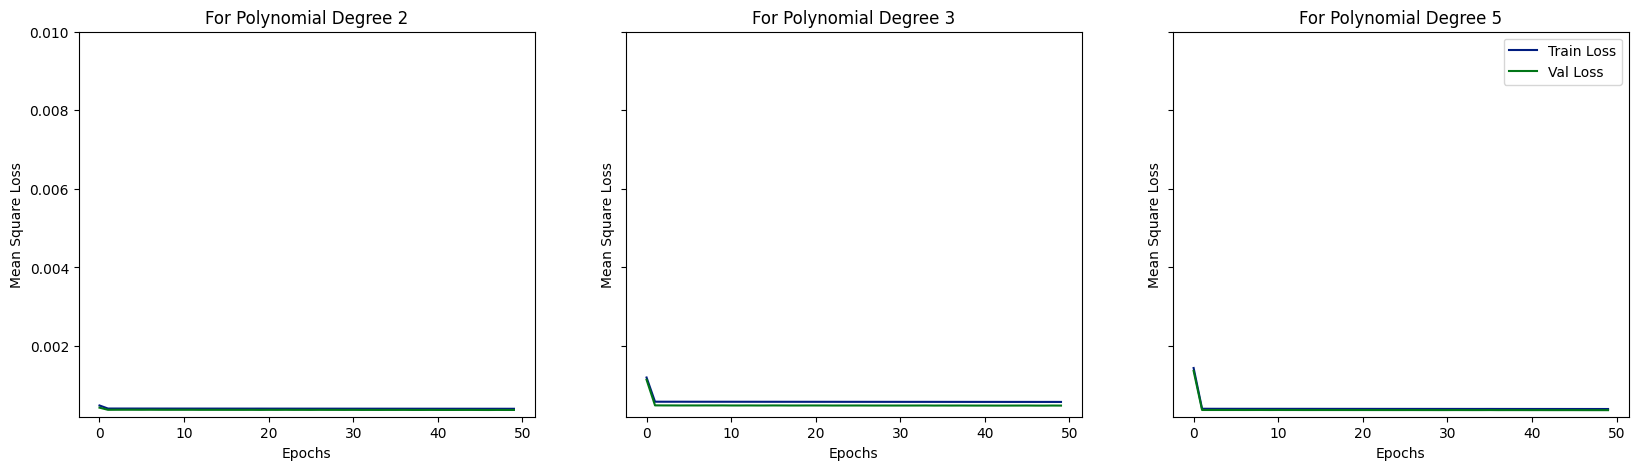

In [38]:
fig,ax = plt.subplots(1,3,figsize=(20,5),sharex=True,sharey=True)
#plt.figure(figsize=(30,15))

keys = list(sgd_deg_dict.keys())
ax[0].plot(sgd_deg_dict[keys[0]][0],label='Train Loss')
ax[0].plot(sgd_deg_dict[keys[0]][1],label='Val Loss')
ax[0].set_title(f"For Polynomial Degree {keys[0]}")
ax[0].set_ylabel("Mean Square Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylim(0.0002,0.01)
ax[1].plot(sgd_deg_dict[keys[1]][0],label='Train Loss')
ax[1].plot(sgd_deg_dict[keys[1]][1],label='Val Loss')
ax[1].set_title(f"For Polynomial Degree {keys[1]}")
ax[1].set_ylabel("Mean Square Loss")
ax[1].set_xlabel("Epochs")
ax[2].plot(sgd_deg_dict[keys[2]][0],label='Train Loss')
ax[2].plot(sgd_deg_dict[keys[2]][1],label='Val Loss')
ax[2].set_title(f"For Polynomial Degree {keys[2]}")
ax[2].set_ylabel("Mean Square Loss")
ax[2].set_xlabel("Epochs")
plt.legend()
plt.show()

### SUMMARY
* LR: 4.0494606414400326e-05
* Lasso: 9.495850733174149e-05
* Ridge: 4.053191115419804e-05
* ENet: 9.495850733174149e-05
* Elastic Net with 0.001 and 0.0: 4.053191115419804e-05
* Polynomial Linear: 4.1686946570443196e-05
* Polynomial Lasso: 9.495850733174149e-05
* Polynomial Ridge: 6.587646794990832e-05
* Polynomial Elastic with default parameters: 9.495850733174149e-05
* Stochasitc gradient descent: 4.0615349e-05

* Thus we can say that the Ridge regression performs well for our dataset with the minimum test set error. Lasso sparse regression model does not seem to work well as it tends to get a sparse model. Also, the SGD model performed well on the dataset
* So,we were able to show that Warren Buffet is indeed a value investor. His portfolio returns are mostly influenced by the market risk and value investment portfolio risk.

# <span style="color:red">FURTHER IMPROVEMENTS</span>
* We can do a hyperparameter sweep for more variables with grid search technique to find the right set of hyperparameters
* Exploring more factors to explain the returns. Currently, we have only 5 factors, but with more factors we can explore more dependencies of the model to better judge if Warren Buffet is a value investor
* We can go for Deep Neural Networks as they can improve with the dimensionality of the data for the regression task
* Windowing the data for training, so that we can do Style analysis for evolving window size